# 0. Ensure required version libraries are installed

You can also "Bring your own image" and use `quay.io/developmentseed/veda-optimized-data-delivery-image:latest`.

In [1]:
!pip list | grep -E '^(icechunk|zarr|xarray)\s'

icechunk                  0.2.12
xarray                    2025.3.2.dev5+g81fe55ad
zarr                      3.0.7.dev5+g3b6565b


In [7]:
import icechunk
import xarray as xr
import zarr
assert(icechunk.__version__ >= "0.2.0")
assert(xr.__version__ >= "2025.0.0")
assert(zarr.__version__ >= "3.0.0")

In [8]:
import virtualizarr
virtualizarr.__version__

'1.3.3.dev32+ge707375'

In [9]:
import boto3
from datetime import datetime, timedelta
import earthaccess
import fsspec
import hvplot.xarray
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
import numpy as np
import panel as pn
from typing import Optional
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import helpers

# 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. 

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

From some adhoc testing, it looks like CPU is saturated at `async.concurrency = ~30` and `threading.max_workers` makes no impact. The default setting for `threading.max_workers` is `None` so presumably this uses all threads available?

In [4]:
zarr.config.set({
    'async': {'concurrency': 100, 'timeout': None},
    'threading': {'max_workers': None}
})

# 2. Set other variables

In [5]:
bucket = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"
lat_range = (47.5, 48.5)
lon_range = (-125.5, -124.5)
lat_min = -90
lon_min = -180
resolution = 0.01
ea_creds = None

# 3. Fetch earthaccess credentials

Note: You can skip this step if you have direct bucket access to `s3://podaac-ops-cumulus-protected/`.

In [6]:
s3 = boto3.client("s3")
bucket_name = 'podaac-ops-cumulus-protected'#helpers.bucket

try:
    response = s3.list_objects_v2(Bucket=bucket_name, MaxKeys=1)
    if "Contents" in response:
        print("Read access confirmed.")
except Exception as e:
    print(f"Read access denied: {e}")
    earthaccess.login()
    ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

Read access confirmed.


# 3. Initialize the repo

In [7]:
def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            s3=icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken']
            )
        )
        repo_config['virtual_chunk_credentials'] = earthdata_credentials
    return icechunk.Repository.open(**repo_config)


In [8]:
repo = get_repo(bucket_name=bucket, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

# Read and plot the icehunk store with xarray

In [30]:
%%time
xds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

CPU times: user 6.28 s, sys: 1.57 s, total: 7.84 s
Wall time: 14.8 s


In [31]:
xds

<xarray.Dataset> Size: 143TB
Dimensions:           (time: 7905, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 63kB 2002-06-01T09:00:00 ... 2024...
Data variables:
    analysis_error    (time, lat, lon) float64 41TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 41TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 20TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 41TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [32]:
xds.analysed_sst.sel(time='2023-01-12', lat=slice(*lat_range), lon=slice(*lon_range)).mean(["lat", "lon"]).load()


<xarray.DataArray 'analysed_sst' (time: 1)> Size: 8B
array([282.64080572])
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-01-12T09:00:00

In [33]:
%%time
xds_subset = xds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range)).mean(["lat", "lon"]).load()

CPU times: user 3min 1s, sys: 27.8 s, total: 3min 29s
Wall time: 7min 2s


CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.7 ms


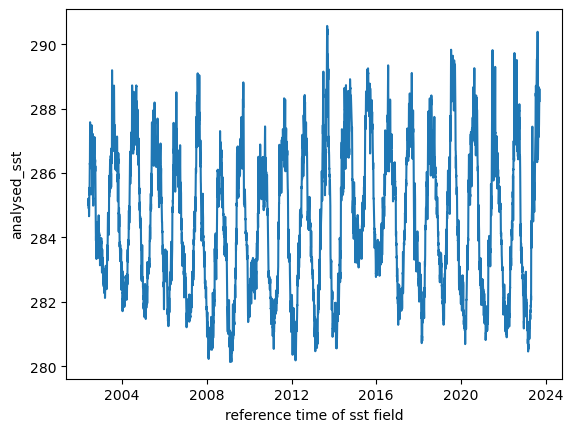

In [34]:
%%time
xds_subset.plot()

# Read and plot the icechunk store with zarr-python

#### 4a. Open zarr store

In [9]:
%%time
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 134 μs, sys: 3.76 ms, total: 3.89 ms
Wall time: 2.64 ms


#### 4b. Create datetime array for plotting

In [10]:
%%time
epoch = datetime(1981, 1, 1)
dt_array = np.array([epoch + timedelta(seconds=int(t)) for t in zarr_store['time'][:]])

CPU times: user 5.56 s, sys: 1.35 s, total: 6.91 s
Wall time: 19 s


#### 4c. Create slice indices from lat and lon ranges

In [11]:
lat_range = list(lat_range)
lon_range = list(lon_range)
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]

#### 4d. Subset and load data

In [12]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

Fetched 79,670,000 points
CPU times: user 2min 50s, sys: 51.1 s, total: 3min 41s
Wall time: 53.5 s


#### 4e. Mask data

In [13]:
%%time
fill_value = zarr_store["analysed_sst"].fill_value
masked_array = np.ma.masked_equal(sst_subset, fill_value)

CPU times: user 379 ms, sys: 96.6 ms, total: 476 ms
Wall time: 475 ms


#### 4f. Calculate spatial mean over time,

In [14]:
%%time
sst_mean = masked_array.mean(axis=(1,2))

CPU times: user 167 ms, sys: 39.5 ms, total: 207 ms
Wall time: 206 ms


#### 4g. Scale result

In [15]:
sst_attrs = zarr_store["analysed_sst"].metadata.attributes
offset, scale = sst_attrs['add_offset'], sst_attrs['scale_factor']
scaled_sst_mean = (sst_mean*scale) + offset

#### 4h. Plot data

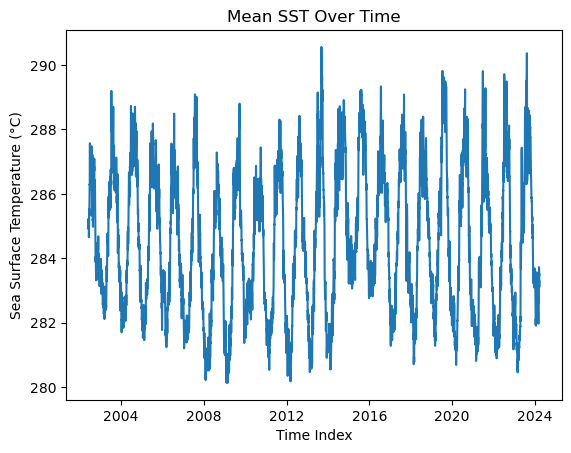

CPU times: user 160 ms, sys: 5.68 ms, total: 166 ms
Wall time: 167 ms


In [16]:
%%time
plt.plot(dt_array, scaled_sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()

# Read and plot 1 month of data from the original files with xarray

In [31]:
%%time
import helpers
dates = ["2004-01-01", "2004-01-31"]
fs_read = fsspec.filesystem("s3", anon=False, skip_instance_cache=True)
og_files = helpers.list_mur_sst_files(start_date=dates[0], end_date=dates[1])
og_ds = xr.open_mfdataset([fs_read.open(f) for f in og_files], parallel=True)

CPU times: user 8.07 s, sys: 4.02 s, total: 12.1 s
Wall time: 31.2 s


In [32]:
%%time
og_data = og_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range)).mean(["lat", "lon"]).load()

CPU times: user 6.83 s, sys: 3.91 s, total: 10.7 s
Wall time: 47.9 s


CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 11.5 ms


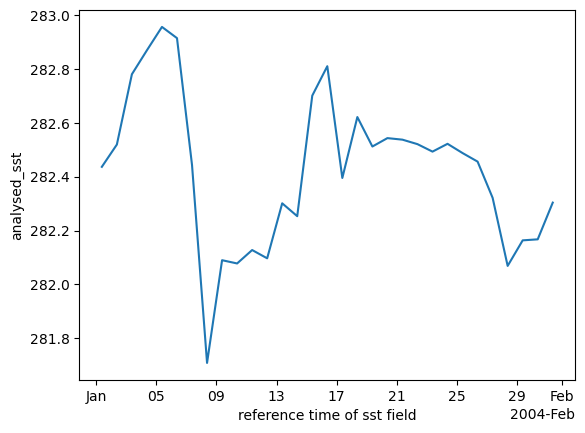

In [33]:
%%time
og_data.plot()

# Visualize the data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
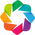

In [20]:
# Enable Panel/HoloViews extensions
hv.extension('bokeh')
pn.extension()

# `masked_array` is from the reading icechunk with zarr-python section
scaled_sst = (masked_array*scale) + offset
shape = scaled_sst.shape

# Get number of time steps
n_times = shape[0]

# Create coordinate arrays
times = zarr_store['time'][:]
# `lat_indices` and `lon_indices` are from the reading icechunk with zarr-python section
lats = zarr_store['lat'][lat_indices[0]:lat_indices[1]]
lons = zarr_store['lon'][lon_indices[0]:lon_indices[1]]

In [22]:
# Create the time index slider
time_slider = pn.widgets.IntSlider(
    name='Time Index', 
    start=0, 
    end=n_times-1, 
    value=0
)

# Create a function to generate the plot for a given time index
def plot_sst(time_idx):
    # Extract the data for the given time step
    time_slice = scaled_sst[time_idx, :, :]
    
    # Format timestamp (adjust based on your time values)
    if isinstance(times[time_idx], np.datetime64):
        time_str = np.datetime_as_string(times[time_idx], unit='D')
    else:
        time_str = f"Step {time_idx}"
    
    # Create a HoloViews Image object
    img = hv.Image((lons, lats, time_slice), kdims=['Longitude', 'Latitude'], vdims=['SST'])
    
    # Apply styling
    img = img.opts(
        opts.Image(
            cmap='turbo',
            colorbar=True,
            clim=(281, 289),
            width=700,
            height=700,
            title=f'Sea Surface Temperature - {time_str}'
        )
    )
    
    return img

# Create a DynamicMap that updates with the slider
dmap = hv.DynamicMap(plot_sst, kdims=['time_idx']).redim.range(time_idx=(0, n_times-1))
# Explicitly bind the DynamicMap to the slider
dmap = dmap.apply(lambda obj: obj.clone(time_idx=time_slider.value))

# Create play/pause widget with a callback to update the slider
player = pn.widgets.Player(
    name='Play',
    start=0,
    end=n_times-1,
    value=0,
    interval=25,  # Update every 200ms - adjust as needed
    loop_policy='loop'
)

# Make sure the player updates the slider, which in turn updates the plot
def update_slider(event):
    time_slider.value = event.new
    
player.param.watch(update_slider, 'value')

# Create a reactive function that outputs a Panel object with the current plot
@pn.depends(time_idx=time_slider)
def get_current_plot(time_idx):
    return plot_sst(time_idx)

# Create the layout
dashboard = pn.Column(
    "## Sea Surface Temperature Time Animation (Direct Zarr)",
    pn.Row(player, time_slider),
    get_current_plot
)

# Display the dashboard
dashboard.servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] Player(end=7966, interval=25, loop_policy='loop', name='Play')
        [1] IntSlider(end=7966, name='Time Index')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)